<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/GaussianMRFExample_lbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Loopy Belief Propagation

We start from the same "image MRF, with unary and pairwise Gaussian factors. We then implement loopy belief propagation.

In [1]:
%pip -q install gtbook  # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
from collections import defaultdict

import gtsam
from gtbook.display import show
from gtsam import noiseModel

def square(vv):
    result = gtsam.VectorValues()
    for k in key_list:
        result.insert(k, vv.at(k)**2)
    return result

## A Small "Image" MRF


All the code to create the small image "MRF" in one cell:

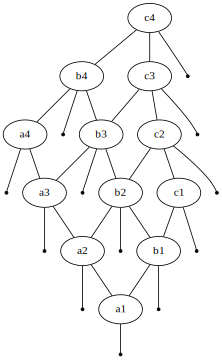

In [3]:
M, N = 3, 4  # try playing with this
row_symbols = [chr(ord('a')+row) for row in range(M)]
keys = {(row, col): gtsam.symbol(row_symbols[row], col+1)
       for row in range(M) for col in range(N)}

sigma = 0.5
rng = np.random.default_rng(42)
data = rng.normal(loc=0, scale=sigma, size=(M, N, 1))
data_model = noiseModel.Isotropic.Sigmas([sigma])

smoothness_sigma = 0.5
smoothness_model = noiseModel.Isotropic.Sigmas([smoothness_sigma])

I = np.eye(1, 1, dtype=float)
zero = np.zeros((1,1))
graph = gtsam.GaussianFactorGraph()
for row in range(M):
    for col in range(N):
        # add data terms:
        j = keys[(row,col)]
        graph.add(j, I, np.array(data[row,col]), data_model)
        # add smoothness terms:
        if col>0:
            j1 = keys[(row,col-1)]
            graph.add(j, I, j1, -I, zero, smoothness_model)
        if row>0:
            j2 = keys[(row-1,col)]
            graph.add(j, I, j2, -I, zero, smoothness_model)

position_hints = {c:float(-i) for i,c in enumerate(row_symbols)}
show(graph, binary_edges=True) # you can add hints=position_hints for a different view

## Loopy Belief Propagation

We initialize a set of individual *Gaussian* factors $q(x_j)$ or *beliefs*, one for each variable. LBP is a fixed point algorithm to minimize the KL $D_\text{KL}(p||q)$ divergence between the true posterior $p(X|Z)$ and the variational approximation

$$
q(X) = \prod_j q(x_j)
$$

We repeatedly:

- pick a variable $x_j$ at random;
- consider the Markov blanket of $x_j$, the factor graph fragment $\phi(x_j, X_j)$ where $X_j$ is the separator;
- augment the factor graph fragment with beliefs on all $x_k\in X_j$, *except* $q(x_j)$;
- eliminate the separator $X_j$ by factorizing $\phi(x_j, X_j) = p(X_j|x_j)q'(x_j)$;
- assign $q(x_j) \leftarrow q'(x_j)$ to be the new belief on $x_j$.

We first cache all Markov blankets:

In [4]:
markov_blankets = defaultdict(gtsam.GaussianFactorGraph)
for i in range(graph.size()):
    factor = graph.at(i)
    for j in factor.keys():
        markov_blankets[j].add(factor)

Here are the Markov blanket for $x_{a1}$ and $x_{b2}$:

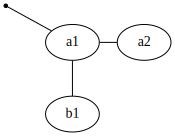

In [5]:
show(markov_blankets[keys[0,0]], binary_edges=True, hints=position_hints)

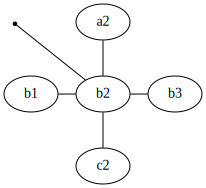

In [6]:
show(markov_blankets[keys[1,1]], binary_edges=True, hints=position_hints)

We initialize the beliefs in *information form* by using a `HessianFactor`, whose constructor reads as follows:

```c++
/** Construct a unary factor.  G is the quadratic term (Hessian matrix), g
* the linear term (a vector), and f the constant term.  The quadratic
* error is:
* 0.5*(f - 2*x'*g + x'*G*x)
*/
HessianFactor(Key j, const Matrix& G, const Vector& g, double f);
```

The entire LPB code is then:

In [7]:
def lbp(x0:gtsam.VectorValues, hook=None, max_iterations=100):
    """Perform loopy belief propagation with initial estimate x."""
    key_list = list(keys.values())
    x = gtsam.VectorValues(x0)
    error = graph.error(x)
    q = {key: gtsam.HessianFactor(key, G=np.eye(1), g=5*np.zeros(
        (1, 1)), f=0) for key in key_list}
    hook(0, None, x, q, error)

    def update(j:int, x:gtsam.VectorValues):
        # Get Markov blanket and augment with beliefs
        augmented_graph = markov_blankets[j]
        augmented_keys = augmented_graph.keys()
        for k in key_list:
            if k != j and augmented_keys.count(k):
                augmented_graph.add(q[k])
        # Eliminate with x_j eliminated last:
        ordering = gtsam.Ordering.ColamdConstrainedLastGaussianFactorGraph(
            augmented_graph, [j])
        gbn = augmented_graph.eliminateSequential(ordering)
        q_prime = gbn.at(gbn.size()-1)
        delta = q_prime.solve(gtsam.VectorValues())
        new_x =  gtsam.VectorValues(x)
        new_x.update(delta) # imperative !
        q[j] = q_prime
        return new_x
                    
    for it in range(1, max_iterations+1):
        if error < 1e-1:
            break
        # choose a variable whose belief to update
        j = key_list[rng.choice(M*N)]
        new_x = update(j, x)
        if new_x is not None:
            error = graph.error(new_x)
            hook(it, j, x, q, error)
            x = new_x
    return x, q

We initialize to the data:

In [8]:
rng = np.random.default_rng(42)
initial = gtsam.VectorValues()
for row in range(M):
    for col in range(N):
        j = keys[(row,col)]
        initial.insert(j, data[row,col])

In [9]:
def print_hook(it, j, x, q, error):
    if it % 1000 == 0:
        if it==0:
            print(f"{it=}, initial error is {error}")
        else:
            print(f"{it=}, updated {gtsam.DefaultKeyFormatter(j)}, error now {error}")

rng = np.random.default_rng(42)
x, q = lbp(initial, print_hook, max_iterations=10000)

it=0, initial error is 12.126645986142575
it=1000, updated b3, error now 3.144896848932315
it=2000, updated a4, error now 3.1445374649678706
it=3000, updated b4, error now 3.1444014545404593
it=4000, updated b3, error now 3.144328703586359
it=5000, updated b2, error now 3.1442837401118875
it=6000, updated a2, error now 3.1442495739463423
it=7000, updated c3, error now 3.1442256092372447
it=8000, updated a3, error now 3.144206276187749
it=9000, updated c2, error now 3.1441907805743736
it=10000, updated b4, error now 3.144178181883217


We compare the mean with the exact mean and see that LBP converges to the correct mean value:

In [10]:
for j, qj in q.items():
    information = qj.information().item()
    stddev = 1.0/math.sqrt(information)
    print(f"{gtsam.DefaultKeyFormatter(j)} {x.at(j).item():.2f} +/- {stddev:.2f}")

a1 -0.16 +/- 0.29
a2 -0.22 +/- 0.25
a3 0.09 +/- 0.25
a4 0.20 +/- 0.29
b1 -0.41 +/- 0.25
b2 -0.30 +/- 0.22
b3 0.00 +/- 0.22
b4 0.06 +/- 0.25
c1 -0.21 +/- 0.29
c2 -0.21 +/- 0.25
c3 0.10 +/- 0.25
c4 0.18 +/- 0.29


In [11]:
mean = graph.optimize()
print("direct solver mean:")
for row in range(M):
    print([np.round(mean.at(keys[(row,col)]).item(),2) for col in range(N)])
print(f"direct solver error: {graph.error(mean)}")

direct solver mean:
[-0.16, -0.22, 0.09, 0.21]
[-0.41, -0.3, 0.0, 0.06]
[-0.21, -0.21, 0.11, 0.18]
direct solver error: 3.1439968801524447


However, convergence is slow.

## Gibbs Sampling

Gibbs sampling is a variant of Markov Chain Monte Carlo sampling that always accepts any proposal.


We repeatedly:

- pick a variable $x_j$ at random;
- consider the Markov blanket of $x_j$, the factor graph fragment $\phi(x_j, X_j)$ where $X_j$ is the separator;
- eliminate the variable $x_j$ by factorizing $\phi(x_j, X_j) = p(x_j|X_j)\phi(X_j)$;
- sample $x_j$ $\phi(x_j, X_j)$.

We first compute all conditionals $p(x_j|X_j)$, which we can do *in advance*, as well as the inverse square root covariances $R_j^{-1}$, which we need for sampling. An advantage of working in square-root information form (like the entirety of GTSAM) is that less computation is needed *and* it is numerically more stable:

In [12]:
key_list = list(keys.values())
conditionals = {}
invR = {}
for j in key_list:
    local_graph = markov_blankets[j]
    # Eliminate just x_j:
    ordering = gtsam.Ordering()
    ordering.push_back(j)
    gbn, _ = local_graph.eliminatePartialSequential(ordering)
    conditionals[j] = gbn.at(0)
    invR[j] = np.linalg.inv(conditionals[j].R())

The conditional is parameterized by $R$, $S$ and $d$ as follows:

$$
p(x_j|X_j) \propto \exp \{-0.5 \|R x_j + S X_j - d\|^2\}
$$

A Gibbs proposal for variable $j$ then just assembles the separator $X_j$ and samples from the conditional like so:

$$
s_j = R_j^{-1} [d - S X_j + u] = \mu(X_j) + R_j^{-1} u
$$

where $\mu(X_j) = R_j^{-1} [d - S X_j]$ is the conditional mean and $u$ is drawn from a standard zero-mean Gaussian with identity covariance. 

In [13]:
rng = np.random.default_rng(42)

def proposal(x, j):
    """Propose via Gibbs sampling"""
    # Get Conditional for x_j, computed above
    conditional = conditionals[j]
    # sample x_j and propose a new sample
    rhs = conditional.d().reshape(1, 1)
    key, *parents = conditional.keys()
    rhs = rhs - conditional.S() @ np.vstack([x.at(p) for p in parents])
    # sample from conditional Gaussian
    sample = gtsam.VectorValues()
    sample.insert(j, invR[j] @ (rhs + rng.normal()))
    new_x = gtsam.VectorValues(x)
    new_x.update(sample)
    return new_x

We also create a hook to keep sufficient statistics:

In [14]:
global count, sum, sum_squares
count = 0
sum = gtsam.VectorValues.Zero(initial)
sum_squares = gtsam.VectorValues.Zero(initial)

def save_stats(it, y):
    global count, sum, sum_squares
    count += 1
    sum = sum.add(y)
    sum_squares = sum_squares.add(square(y))

The Gibbs sampler is then *exceedingly simple*:

In [15]:
# run Gibbs sampler
nr_iterations = 10000
y = gtsam.VectorValues(initial)
for it in range(nr_iterations):
    j = key_list[rng.choice(M*N)] # choose a variable to perturb
    y = proposal(y, j)
    if it >= nr_iterations//2: save_stats(it, y)

Because we kept the sufficient statistics `count`, `sum`, and `sum_squares` we can compute the marginals:

In [16]:
mean = sum.scale(1.0/count)
avg_deviation = sum_squares.scale(1.0/count)
variance = avg_deviation.subtract(square(mean))

print(f"Marginals computed from {count} correlated samples:")
for j in key_list:
    stddev = math.sqrt(variance.at(j))
    print(f"{gtsam.DefaultKeyFormatter(j)} {mean.at(j).item():.2f} +/- {stddev:.2f}")
print(f"The error at the mean is {graph.error(mean)}.")

Marginals computed from 5000 correlated samples:
a1 -0.20 +/- 0.31
a2 -0.27 +/- 0.29
a3 0.07 +/- 0.28
a4 0.17 +/- 0.30
b1 -0.41 +/- 0.29
b2 -0.31 +/- 0.24
b3 -0.02 +/- 0.27
b4 0.01 +/- 0.29
c1 -0.24 +/- 0.31
c2 -0.24 +/- 0.24
c3 0.09 +/- 0.28
c4 0.16 +/- 0.30
The error at the mean is 3.182681831505461.


Comparing these with the direct solver solution above you can see that the mean converges, *as well as the standard deviations*. We can print the ground truth standard deviations with the direct solver:

In [17]:
bayes_tree = graph.eliminateMultifrontal()
exact_mean = bayes_tree.optimize()
for j in key_list:
    variance = bayes_tree.marginalCovariance(j)
    stddev = math.sqrt(variance)    
    print(f"{gtsam.DefaultKeyFormatter(j)} {exact_mean.at(j).item():.2f} +/- {stddev:.2f}")


a1 -0.16 +/- 0.33
a2 -0.22 +/- 0.29
a3 0.09 +/- 0.29
a4 0.21 +/- 0.33
b1 -0.41 +/- 0.29
b2 -0.30 +/- 0.26
b3 0.00 +/- 0.26
b4 0.06 +/- 0.29
c1 -0.21 +/- 0.33
c2 -0.21 +/- 0.29
c3 0.11 +/- 0.29
c4 0.18 +/- 0.33


Note that 
- the standard deviations at the edge are larger.
- comparing with LBP, we see that the LBP approximation is overly confident. This is a well known property of LBP.